# Однофакторный анализ связи меток кред и фрод дефолта target.class с данными таблиц Фед ресурса efrsfdu базы данных VLS-MDM-DB MDM_Main по фичам (часть 2)

    - сколько закрытых договоров имеется на дату принятия решения 
    - сколько закрытых договоров по типам причин имеется на дату принятия решения 
    - Количество расторгнутых договоров
    - Среднее количество расторгнутых (плохих) договоров до дня принятия решения

Входные данные data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи

In [1]:
import pandas as pd

In [2]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [3]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))

Размер считанных данных target_class with mdm features- (85798, 39)


In [4]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/analysis_features_part2.xlsx"
writer = ExcelWriter(name)

In [5]:
# target_features.head(2)

#### Теперь формируем выборки для фрод и кред дефолта

In [6]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению
target_cred = Target(type='кред', target_data=target_features)# это кред дефолт, макс по обращению

target_frod.print_param()
target_cred.print_param()


Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4708 из 63131 (7.46%)

Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1977 из 43723 (4.52%)


In [7]:
# target_frod.data.head(2)

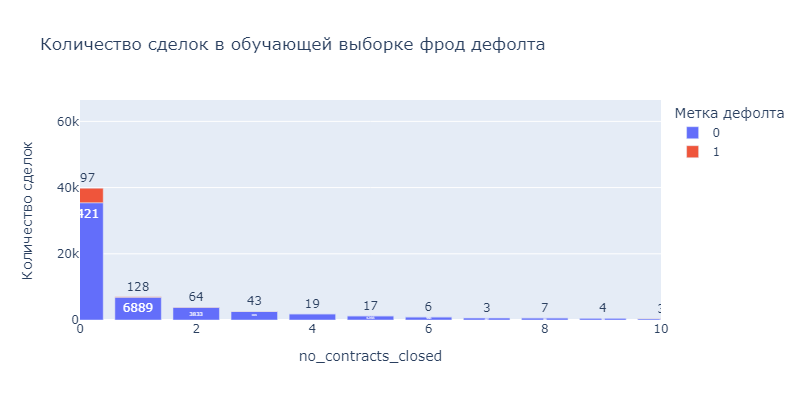

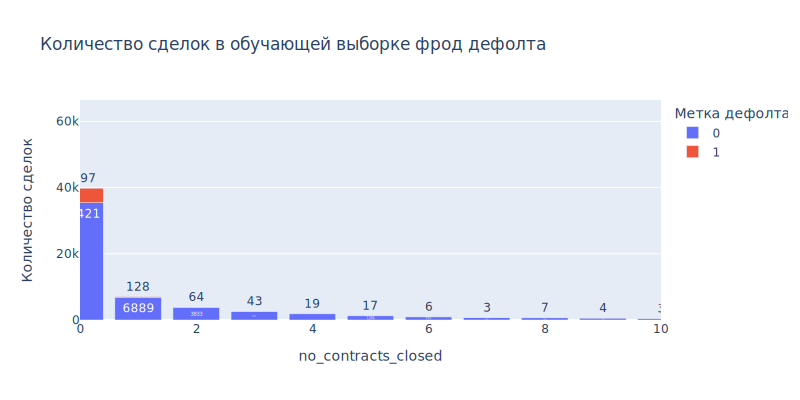

In [9]:
plot_features_bar(target_frod.data, 'no_contracts_closed', x_range =[0, 10])

In [47]:
#  статиcтика по фичам
stat = target_frod.data['no_contracts_closed'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_closed':'frod_contracts_closed'})
stat = stat.append(target_frod.data['reason_расторгнут'].apply(['min', 'max', 'mean']).to_frame().T.rename({'reason_расторгнут':'frod_contracts_расторгнут'}))

stat = stat.append(target_cred.data['no_contracts_closed'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_closed':'cred_contracts_closed'}))
# stat = stat.append(target_cred.data['no_contracts_total'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_total':'cred_contracts_total'}))

stat.to_excel(writer, sheet_name='stat_features')
stat


,min,max,mean
frod_contracts_closed,0.0,276.0,2.388652
frod_contracts_расторгнут,0.0,31.0,0.082131
cred_contracts_closed,0.0,276.0,2.330192


## Logregression количества закрытых договоров на день принятия решения по нашей сделке

### Дефолтные сделки по всем закрытым договорам до даты принятия решения (фрод метка)

{'rocauc': 0.67, 'accuracy': 0.44, 'recall': 0.93}
{'intercept': -0.6327, 'coef': array([-3.0602])}


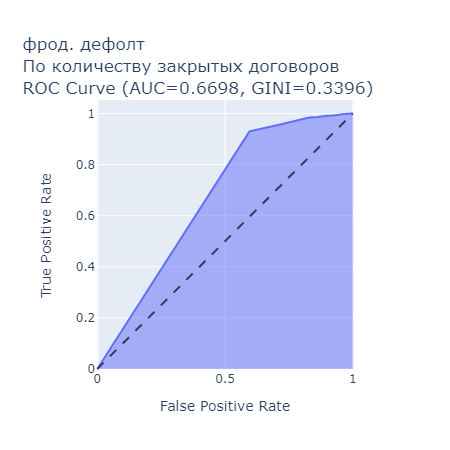

In [48]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['no_contracts_closed']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству закрытых договоров')

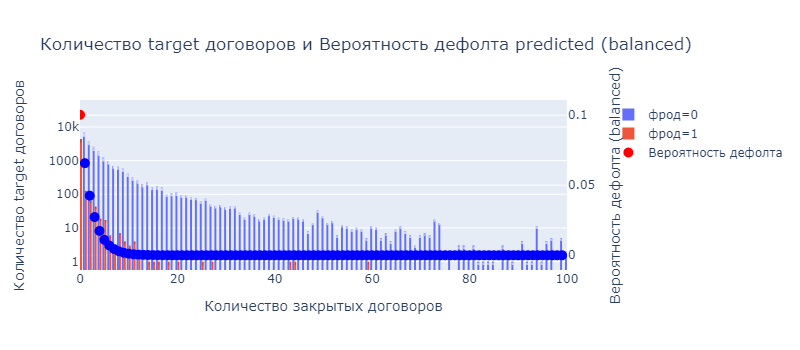

In [49]:
y_pred, y_prob = log.predict(np.arange(0, 100))
df_second = pd.DataFrame({'X':np.arange(0, 100), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_contracts_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_contracts_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по расторгнутым договорам до даты принятия решения (фрод метка)

In [50]:
# target_frod.data.head(1)

{'rocauc': 0.52, 'accuracy': 0.11, 'recall': 0.99}
{'intercept': -0.0108, 'coef': array([-0.2144])}


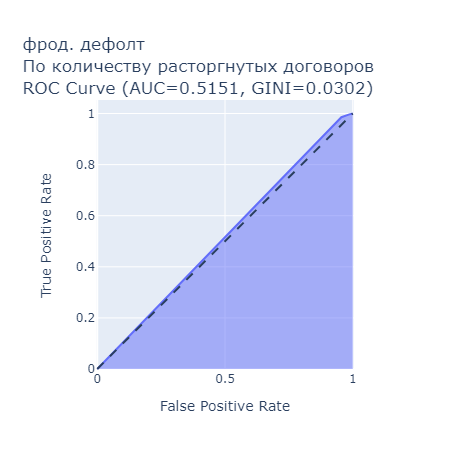

In [51]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['reason_расторгнут']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
# log.print_predictions(x_lable = 'No. договоров на дату решения', type = type, title="Значения predicted по всем договорам до даты принятия решения", slice=slice(0, 7))
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству расторгнутых договоров')

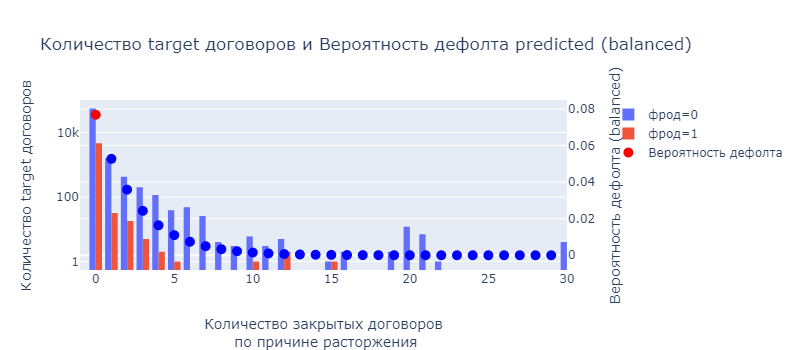

In [52]:
y_pred, y_prob = log.predict(np.arange(0, 30))
df_second = pd.DataFrame({'X':np.arange(0, 30), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='reason_расторгнут', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 30], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('reason_расторгнут', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по всем причинам завершения договоров (фрод метка)

In [53]:
col = target_frod.data.columns
col_reasons = col[col.str.startswith('reason_')]
col_reasons

Index(['reason_гибель/тотал', 'reason_завершение',
       'reason_замена/перенайм/переуступка', 'reason_не указана',
       'reason_определена цессия', 'reason_отмена', 'reason_расторгнут',
       'reason_страховой случай', 'reason_страховой случай (гибель/тотал)'],
      dtype='object')

{'rocauc': 0.67, 'accuracy': 0.43, 'recall': 0.94}
{'intercept': -0.6982, 'coef': array([-4.0000e-04, -1.7501e+00, -1.0720e-01, -1.4806e+00, -1.7900e-02,
       -9.0460e-01,  9.7600e-02, -3.8940e-01, -1.0200e-01])}


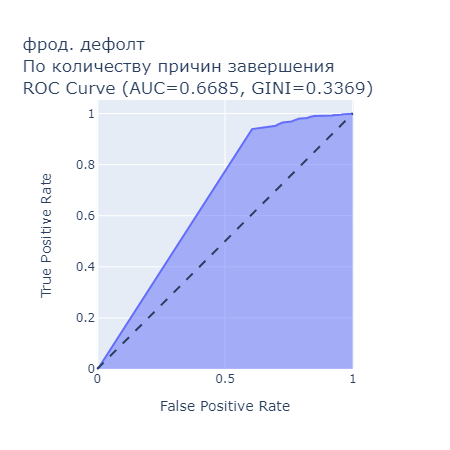

In [54]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[col_reasons])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству причин завершения')

In [55]:
pd.DataFrame({'reason':col_reasons, 'coef':log.model.coef_[0]}).sort_values(by='coef')

,reason,coef
1,reason_завершение,-1.750112
3,reason_не указана,-1.480604
5,reason_отмена,-0.904617
7,reason_страховой случай,-0.389363
2,reason_замена/перенайм/переуступка,-0.107221
8,reason_страховой случай (гибель/тотал),-0.101969
4,reason_определена цессия,-0.017931
0,reason_гибель/тотал,-0.000419
6,reason_расторгнут,0.097554


видно, что на увеличение вероятности дефолта влияют:
- гибель/тотал, 
- определена цессия
- расторгнут

на уменьшение вероятности дефолта влияют в порядке степени:
- причина не указана
- завершение
- отмена ( возможно нужно просто удалить такие договоры)
- страховой случай
- замена/перенайм/переуступка
- страховой случай (гибель/тотал)

{'rocauc': 0.67, 'accuracy': 0.43, 'recall': 0.94}
{'intercept': 0.2643, 'coef': array([ 0.    , -0.5072, -0.6529, -0.3001, -0.0534, -0.6222,  0.1437,
       -1.4414, -0.4574])}


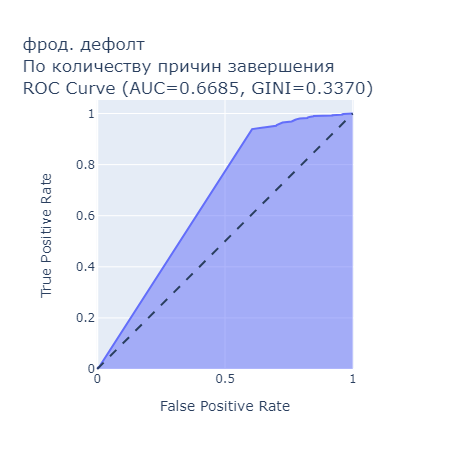

,reason,coef
7,reason_страховой случай,-1.441413
2,reason_замена/перенайм/переуступка,-0.652920
5,reason_отмена,-0.622207
1,reason_завершение,-0.507176
8,reason_страховой случай (гибель/тотал),-0.457424
3,reason_не указана,-0.300137
4,reason_определена цессия,-0.053404
0,reason_гибель/тотал,0.000043
6,reason_расторгнут,0.143688


In [56]:
#  тоже самое но не нормируем
type = target_frod.type

X_raw = np.asarray(target_frod.data[col_reasons])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y, norm=False)


log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству причин завершения')
pd.DataFrame({'reason':col_reasons, 'coef':log.model.coef_[0]}).sort_values(by='coef')

При нормировании и без 
итоговые такие же показатели (roc, auc), знаки у коэффициентов такие же, показывают то же направление, сами коэффициенты имеют меньший разброс, вес разреженных значений больше

### Дефолтные сделки по среднему количеству плохо завершенных договоров (фрод метка)

плохим завершением будем считать те причины указанные, по которым мы видела увеличение вероятности дефолта, а именно:
- гибель/тотал, 
- определена цессия
- расторгнут

In [57]:
bad_reasons = ['reason_гибель/тотал', 'reason_определена цессия','reason_расторгнут']
target_frod.data['bad_reasons'] = target_frod.data[bad_reasons].sum(axis=1)

In [58]:
#  статиcтика по фичам
stat = target_frod.data['bad_reasons'].apply(['min', 'max', 'mean']).to_frame().T.rename({'bad_reasons':'frod_contracts_bad'})

stat.to_excel(writer, sheet_name='stat_features2')
stat

,min,max,mean
frod_contracts_bad,0.0,52.0,0.094866


In [59]:
mask = (target_frod.data['no_contracts_closed']==0)

# target_frod.data.loc[mask, 'mean_bad_reasons'] = -1
target_frod.data.loc[mask, 'mean_bad_reasons'] = 0
target_frod.data.loc[~mask, 'mean_bad_reasons'] = target_frod.data.loc[~mask, 'bad_reasons']/target_frod.data.loc[~mask, 'no_contracts_closed']

# target_frod.data.head()

Тут я думаю, надоанализировать только тех, у кого эти завершенные договоры были, у кого не было, надо из анализа выкинуть

In [60]:
#  статиcтика по фичам
mask = (target_frod.data['no_contracts_closed']>0)
df = target_frod.data[mask]
stat = df['mean_bad_reasons'].apply(['min', 'max', 'mean']).to_frame().T.rename({'mean_bad_reasons':'frod_mean_bad_reasons'})

stat.to_excel(writer, sheet_name='stat_features3')
stat

,min,max,mean
frod_mean_bad_reasons,0.0,1.0,0.046662


{'rocauc': 0.59, 'accuracy': 0.89, 'recall': 0.28}
{'intercept': -0.0541, 'coef': array([0.2685])}


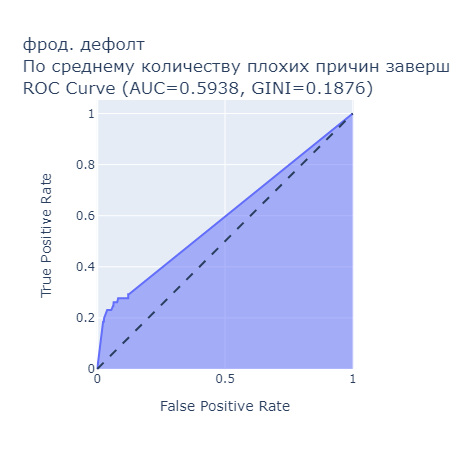

In [61]:
mask = (target_frod.data['no_contracts_closed']>0)
df = target_frod.data[mask]

type = target_frod.type

X_raw = np.asarray(df[['mean_bad_reasons']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По среднему количеству плохих причин завершения')

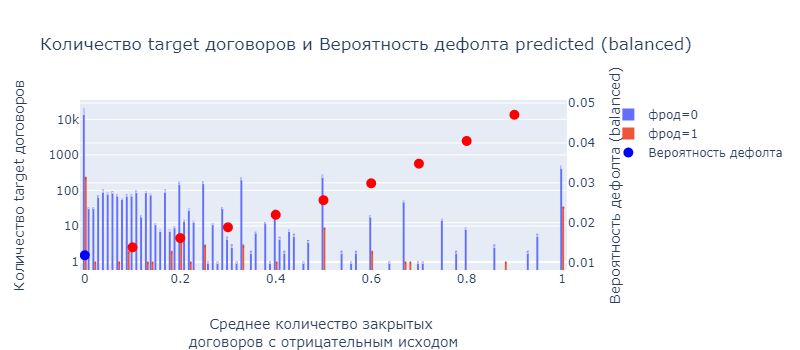

In [62]:
y_pred, y_prob = log.predict(np.arange(0, 1, 0.1))
df_second = pd.DataFrame({'X':np.arange(0, 1, 0.1), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data[mask].copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='mean_bad_reasons', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-0.01, 1.01], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('mean_bad_reasons', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

{'rocauc': 0.52, 'accuracy': 0.12, 'recall': 0.98}
{'intercept': -0.0035, 'coef': array([-0.0926])}


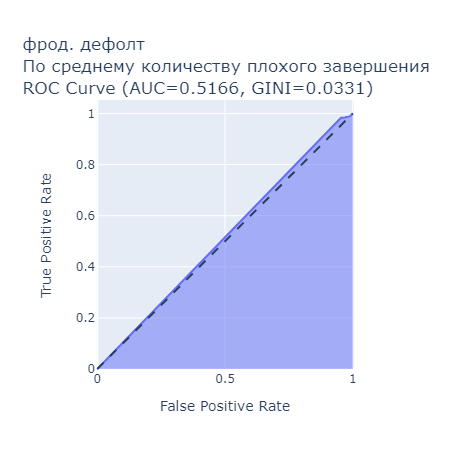

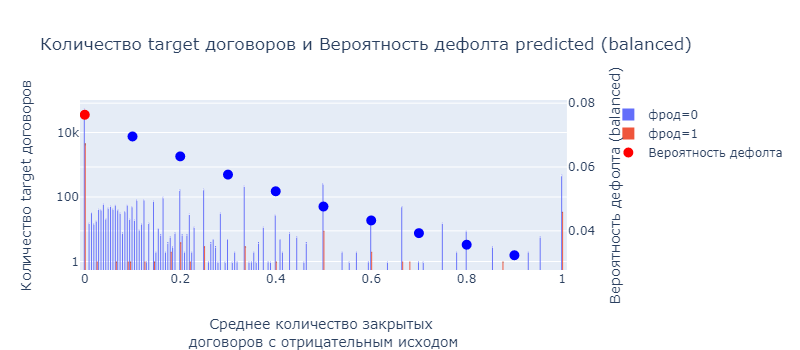

In [63]:
#смотрим по всем, у кого нет закрытых договоров считаем что mean_bad_reasons = 0
type = target_frod.type

X_raw = np.asarray(target_frod.data[['mean_bad_reasons']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По среднему количеству плохого завершения')

y_pred, y_prob = log.predict(np.arange(0, 1, 0.1))
df_second = pd.DataFrame({'X':np.arange(0, 1, 0.1), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='mean_bad_reasons', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-0.01, 1.01], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('mean_bad_reasons', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

# Log - regression по меткам кред дефолта

### Дефолтные сделки по всем договорам до даты принятия решения (кред метка)

{'rocauc': 0.57, 'accuracy': 0.31, 'recall': 0.87}
{'intercept': -0.0462, 'coef': array([-0.4211])}


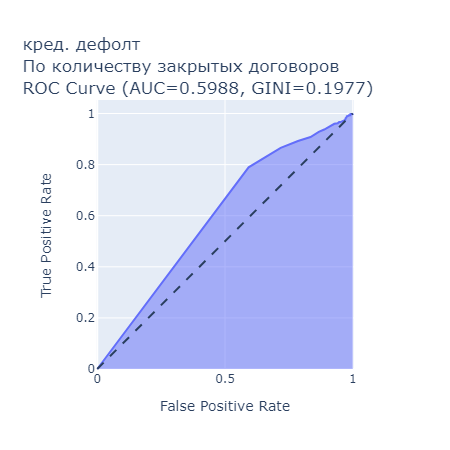

In [64]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['no_contracts_closed']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
# log.print_predictions(x_lable = 'No. договоров на дату решения', type = type, title="Значения predicted по всем закрытым договорам до даты принятия решения", slice=slice(0, 7))
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству закрытых договоров')

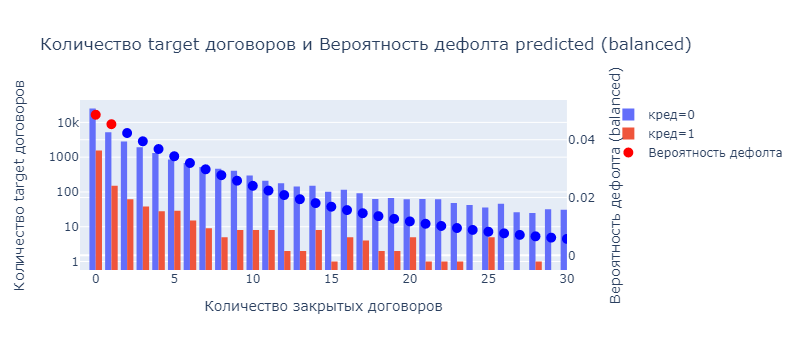

In [65]:
y_pred, y_prob = log.predict(np.arange(0, 100))
df_second = pd.DataFrame({'X':np.arange(0, 100), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_contracts_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 30], 
                height= 350, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('no_contracts_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по расторгнутым договорам до даты принятия решения (кред метка)

{'rocauc': 0.5, 'accuracy': 0.91, 'recall': 0.04}
{'intercept': -0.0016, 'coef': array([0.0609])}


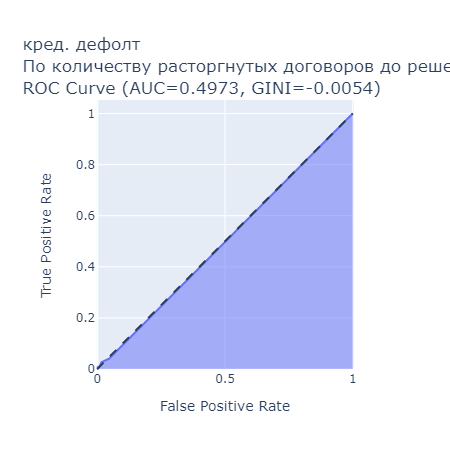

In [66]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['reason_расторгнут']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
# log.print_predictions(x_lable = 'No. договоров на дату решения', type = type, title="Значения predicted по всем договорам до даты принятия решения", slice=slice(0, 7))
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству расторгнутых договоров до решения')

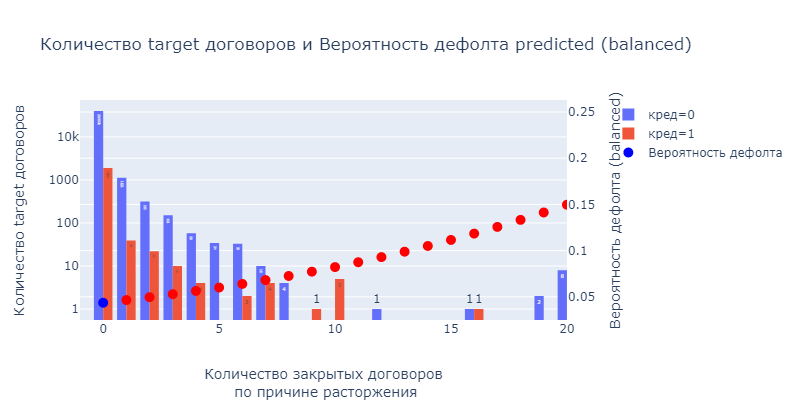

In [67]:
y_pred, y_prob = log.predict(np.arange(0, 30))
df_second = pd.DataFrame({'X':np.arange(0, 30), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='reason_расторгнут', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 20], 
                height= 400, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('reason_расторгнут', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по всем причинам завершения договоров (кред метка)

In [68]:
col = target_cred.data.columns
col_reasons = col[col.str.startswith('reason_')]
col_reasons

Index(['reason_гибель/тотал', 'reason_завершение',
       'reason_замена/перенайм/переуступка', 'reason_не указана',
       'reason_определена цессия', 'reason_отмена', 'reason_расторгнут',
       'reason_страховой случай', 'reason_страховой случай (гибель/тотал)'],
      dtype='object')

{'rocauc': 0.58, 'accuracy': 0.32, 'recall': 0.87}
{'intercept': -0.0834, 'coef': array([ 0.0486, -0.2146, -0.1988, -0.4033,  0.0342, -0.1547,  0.1728,
       -0.0736,  0.0314])}


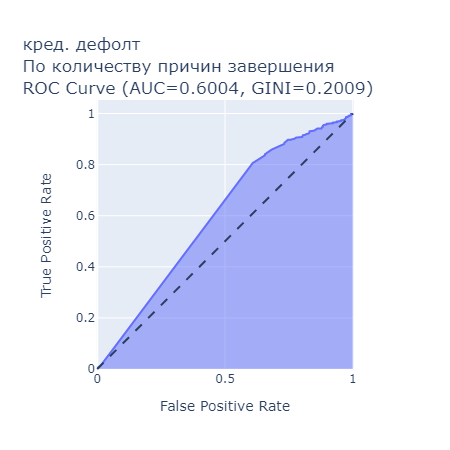

In [69]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[col_reasons])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству причин завершения')

In [70]:
pd.DataFrame({'reason':col_reasons, 'coef':log.model.coef_[0]}).sort_values(by='coef')

,reason,coef
3,reason_не указана,-0.403265
1,reason_завершение,-0.214618
2,reason_замена/перенайм/переуступка,-0.198751
5,reason_отмена,-0.154688
7,reason_страховой случай,-0.073586
8,reason_страховой случай (гибель/тотал),0.031388
4,reason_определена цессия,0.034199
0,reason_гибель/тотал,0.048635
6,reason_расторгнут,0.172795


видно, что на увеличение вероятности дефолта влияют:
- гибель/тотал, 
- определена цессия
- расторгнут
- отмена ( возможно нужно просто удалить такие договоры) ( в отличие от фрод дефолта)

на уменьшение вероятности дефолта влияют в порядке степени:
- причина не указана
- завершение
- страховой случай
- замена/перенайм/переуступка
- страховой случай (гибель/тотал)

### Дефолтные сделки по среднему количеству плохо завершенных договоров кред метка)

плохим завершением будем считать те причины указанные, по которым мы видела увеличение вроятности дефолта, а именно:
- гибель/тотал, 
- определена цессия
- расторгнут
- отмена

In [71]:
bad_reasons = ['reason_гибель/тотал', 'reason_определена цессия','reason_расторгнут', 'reason_отмена']
target_cred.data['bad_reasons'] = target_cred.data[bad_reasons].sum(axis=1)

In [72]:
mask = (target_cred.data['no_contracts_closed']==0)

# target_cred.data.loc[mask, 'mean_bad_reasons'] = -1
target_cred.data.loc[mask, 'mean_bad_reasons'] = 0
target_cred.data.loc[~mask, 'mean_bad_reasons'] = target_cred.data.loc[~mask, 'bad_reasons']/target_cred.data.loc[~mask, 'no_contracts_closed']

# target_cred.data.head()

Тут я думаю, надоанализировать только тех, у кого эти завершенные договоры были, у кого не было, надо из анализа выкинуть

{'rocauc': 0.57, 'accuracy': 0.69, 'recall': 0.45}
{'intercept': -0.0321, 'coef': array([0.2434])}


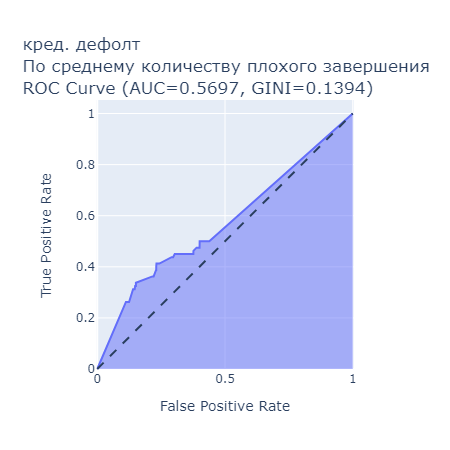

In [73]:
mask = (target_cred.data['no_contracts_closed']>0)
df = target_cred.data[mask]

type = target_cred.type

X_raw = np.asarray(df[['mean_bad_reasons']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По среднему количеству плохого завершения')

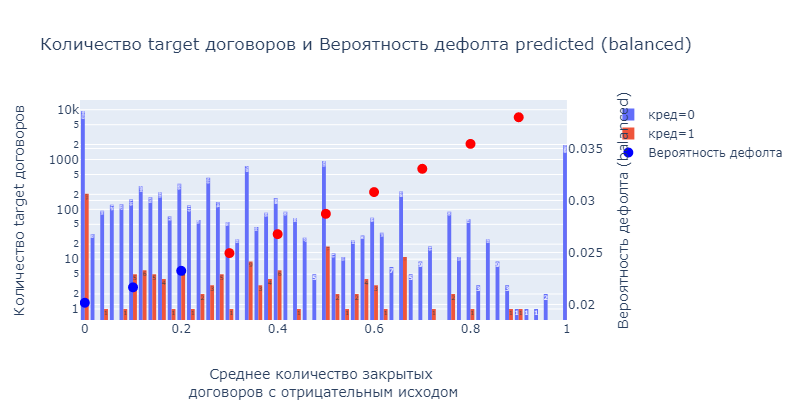

In [74]:
mask = (target_cred.data['no_contracts_closed']>0)

y_pred, y_prob = log.predict(np.arange(0, 1, 0.1))
df_second = pd.DataFrame({'X':np.arange(0, 1, 0.1), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data[mask].copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='mean_bad_reasons', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-0.01, 1], 
                height= 400, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('mean_bad_reasons', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

{'rocauc': 0.53, 'accuracy': 0.21, 'recall': 0.89}
{'intercept': -0.0033, 'coef': array([-0.0852])}


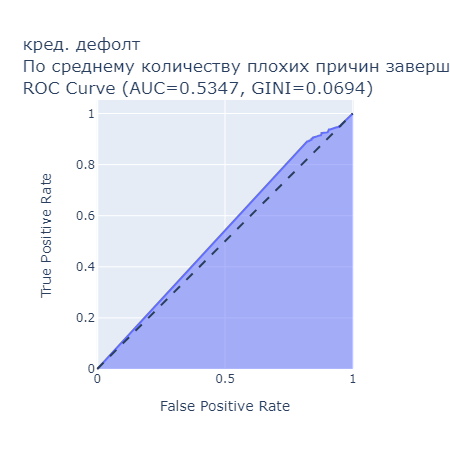

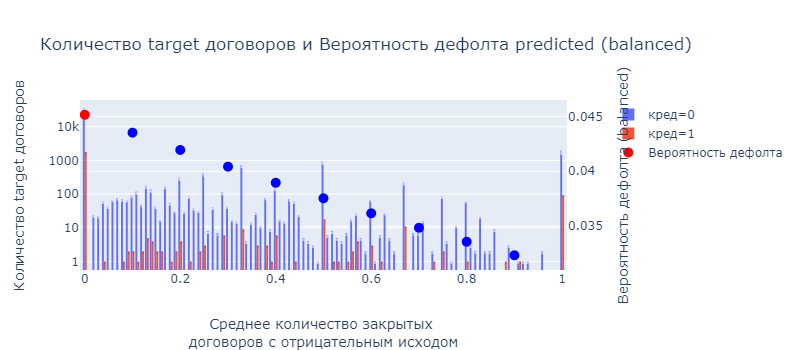

In [75]:
#смотрим по всем, у кого нет закрытых договоров считаем что mean_bad_reasons = 0
X_raw = np.asarray(target_cred.data[['mean_bad_reasons']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По среднему количеству плохих причин завершения')

y_pred, y_prob = log.predict(np.arange(0, 1, 0.1))
df_second = pd.DataFrame({'X':np.arange(0, 1, 0.1), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='mean_bad_reasons', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-0.01, 1.01], 
                height= 350, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('mean_bad_reasons', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

In [76]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()